# Pleasant Lake worked Flopy example

This worked example uses Flopy to  
* develop a geo-located model grid, 
* map input to the grid, 
* create MODFLOW input files
* visualize model results.

In addition,
* [SFRmaker](https://doi.org/10.1111/gwat.13095) is used with flopy to construct the Streamflow Routing Package for MODFLOW
* [Numpy](https://numpy.org) is used for some basic array operations
* [Matplotlib](https://matplotlib.org/) is used along with Flopy to visualize the model results


The example is based on the Pleasant Lake MODFLOW 6 model published by Fienen et al. (2022), which was created to evaluate groundwater abstraction impacts on the ecological function of Pleasant Lake in central Wisconsin, USA. While simplified from the original work (available from [Fienen et al. (2021)](https://doi.org/10.5066/P9BVFSGJ), the example is still similar to a "real world" application in that it includes Streamflow Routing and Lake Package boundary conditions, and specification of input through external text array files that are amenable to parameter estimation. 

### Imports
We start by importing the required packages and objects:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import flopy
import flopy.mf6 as mf6
from flopy.discretization import StructuredGrid
from flopy.utils import Raster
import sfrmaker

ModuleNotFoundError: No module named 'flopy'

### Basic model information
Next we define a name and folder location for the model. We then define the discretization and orientation of the model grid in a coordinate reference system (in this case, Wisconsin Transverse Mercator, denoted by EPSG code 3070). 

In [2]:
model_name = 'pleasant'
workspace = '.'

nper, nlay, nrow, ncol = 1, 3, 60, 70
delr, delc = 40, 40
xoffset, yoffset = 554400., 389200.0
epsg = 3070

modelgrid = StructuredGrid(
    delr=np.ones(ncol) * delr,
    delc=np.ones(nrow) * delc,
    xoff=xoffset, yoff=yoffset, angrot=0)

NameError: name 'StructuredGrid' is not defined

### Show intersecting a single raster with model grid using flopy's Raster class
The ``Raster`` class in Flopy can be used to interpolate raster surfaces onto the geolocated model grid. In this case, elevations from the impermeable bedrock surface at the base of the model are interpolated linearly to the model grid cell centers. The ``Raster`` class returns a Numpy array of the same shape as the model, which can be written to a text file that can be read directly by MODFLOW.

In [3]:
br_surf = Raster.load('data/br_surface.tif')
rs = br_surf.resample_to_grid(
    modelgrid, band=1, method='linear')
np.savetxt('data/botm_002.dat', rs)

### External array files
Similar operations can be performed to produce text file arrays for other model properties. For example, Flopy can export a shapefile of the model grid, which can then be used in a GIS environment to compute zonal statistics of land surface elevations or to map other properties to the grid. Or text file arrays might be produced by parameter estimation software such as PEST. We list text file inputs together in the block below for easy reference. Broadly, these external files fall into two categories-- array files of spatially continuous values for each cell (with one file per layer or stress period), and tabular files of sparse input values (one per stress period) with location and attribute information (e.g. row/column/layer or node number, flux, elevation, stage, conductance, etc.). In the example below, hydraulic conductivity, recharge and cell top and bottom elevations are contained in arrays; specified heads along the model perimeter are contained in a table externally (e.g. through GIS) mapped to layer, row, column locations in the grid.

In [4]:
top = [{'filename': 'data/top.dat'}]
botm = [{'filename': 'data/botm_000.dat'},
        {'filename': 'data/botm_001.dat'},
        {'filename': 'data/botm_002.dat'}]
# hydraulic conductivity
k = [{'filename': 'data/k_000.dat'},
     {'filename': 'data/k_001.dat'},
     {'filename': 'data/k_002.dat'}]
# vertical hydraulic conductivity
k33 = [{'filename': 'data/k33_000.dat'},
       {'filename': 'data/k33_001.dat'},
       {'filename': 'data/k33_002.dat'}]
# use the model top for starting heads
strt = [top[0]] * nlay
recharge = {
    0: {'filename': 'data/rch_000.dat'}}
irch = [{'filename': 'data/irch.dat'}]
spec_head_perimeter = {
    0: {'filename': 'data/chd_000.dat'}}

### Set up the model in Flopy
Now that we've defined the model grid and listed the key external file inputs, we're ready to construct the model in Flopy. In general, Flopy represents each input file to MODFLOW with its own python object class. The MODFLOW 6 and Flopy documentation provide more details on the input structures to MODFLOW 6 and Flopy. Here we start by creating a simulation class instance, which represents the Simulation Name File in MODFLOW 6.

In [5]:
sim = mf6.MFSimulation(
    sim_name=model_name, version="mf6", 
    exe_name="./bin/win/mf6.exe", sim_ws=workspace)

Next we create object instances for the simulation level packages that would be shared by all models contained within a MODFLOW 6 simulation. These include the Temporal Discretization (TDIS) and Iterative Matrix Solution (IMS) Packages.

In [6]:
tdis = mf6.ModflowTdis(
    sim, time_units="days", nper=1, 
    perioddata=[(1.0, 1, 1.0)])

ims = mf6.ModflowIms(
    sim, complexity="moderate", 
    outer_dvclose=0.001)

Now that the simulation is established, we can make the groundwater model. The ``ModflowGwf`` class represents the groundwater model and the Name file. Next, we create class instances for the Output Control and Discretization Packages. We opt to save the head and flow solutions to MODFLOW binary output, so that we can view them later. We also use information from the stand-alone model grid that we made earlier to locate the model grid object attached to the Flopy model, so that Flopy will write the correct spatial reference information to the Name file.

In [1]:
# create the model instance
gwf = mf6.ModflowGwf(
    sim, modelname=model_name, 
    save_flows=True)

# output control
oc = mf6.ModflowGwfoc(
    gwf, head_filerecord=f'{gwf.name}.hds', 
    budget_filerecord=f'{gwf.name}.cbc',
    saverecord=[('head', 'all'), ("budget", "all")])
                
# set up the discretization package
dis = mf6.ModflowGwfdis(
    gwf, nlay=nlay, nrow=nrow, ncol=ncol,
    delr=delr, delc=delc, 
    top=top, botm=botm, idomain=1)

# locate the model grid
gwf.modelgrid.set_coord_info(
    xoff=xoffset, yoff=yoffset, epsg=epsg)
gwf.modelgrid

NameError: name 'mf6' is not defined

### Assign aquifer properties
Next, we assign aquifer properties. Since this is a steady-state model, we need only include the Node Property Flow (NPF) package, which specifies hydraulic conductivity.

In [8]:
npf = mf6.ModflowGwfnpf(
    gwf, icelltype=1, k=k, k33=k33)

### Assign initial conditions
Starting heads for the model are assigned via the Initial Conditions (IC) Package. Earlier in the workflow, we assigned a text file array of the model top elevation to the ``strt`` variable (starting heads for the model solution).

In [9]:
ic = mf6.ModflowGwfic(gwf, strt=strt)

### Assign boundary conditions
Finally, we assign boundary conditions. Similar to other packages, we specify perimeter heads to the Constant Head Package via an external table, and steady state recharge via a text array file. An external connection data table for the Lake Package lists each model cell connected to the lake, as well as the leakance and orientation of each connection. The ``packagedata`` argument contains the initial stage, number of connections, and "boundname" for each lake (Langevin et al., 2017). Lake water balance components are specified under ``perioddata``, a python dictionary with keys being stress periods and values being lists. This type of data structure is used frequently for transient data in Flopy. An external table specifies the relationship between stage, area and volume for the lake.

In [10]:
chd = mf6.ModflowGwfchd(
    gwf, stress_period_data=spec_head_perimeter)
rch = mf6.ModflowGwfrcha(
    gwf, recharge=recharge, irch=irch)

lak = mf6.ModflowGwflak(
    gwf,
    boundnames=True, nlakes=1,
    connectiondata={
        'filename': 'data/lake_cn.dat'},
    packagedata=[[0, 290.85, 345, 'lake1']],
    perioddata={0: [
        [0, 'evaporation', 0.000715], 
        [0, 'rainfall', 0.00209]]},
    surfdep=0.1)

### Streamflow Routing Package input
The creation of Streamflow Routing (SFR) Package input is handled by SFRmaker (Leaf et al., 2021), which takes a shapefile of hydrography and a digital elevation model raster as input, and adds the package to the Flopy model object.

In [11]:
# lines = sfrmaker.Lines.from_shapefile(
#     shapefile='data/edited_flowlines.shp',
#     id_column='id',
#     routing_column='toid',
#     width1_column='width1',
#     width2_column='width2',
#     name_column='name',
#     attr_length_units='meters'
#     )
# sfrdata = lines.to_sfr(
#     model=gwf, 
#     model_length_units='meters')
# sfrdata.set_streambed_top_elevations_from_dem(
#     'data/dem40m.tif', 
#     elevation_units='meters')
# sfrdata.assign_layers()
# sfr = sfrdata.create_mf6sfr(gwf)

### Writing the input files
Now that all the packages are made, we can write the MODFLOW input files.

In [12]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model pleasant...
    writing model name file...
    writing package oc...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 572 based on size of stress_period_data
    writing package rcha_0...
    writing package lak_0...


### Running the model with Flopy
MODFLOW can be run at the command line, or through Flopy, as shown here.

In [13]:
sim.run_simulation()

FloPy is using the following executable to run the model: ./bin/win/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/04/2022

   MODFLOW 6 compiled Mar 07 2022 16:14:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall

(True, [])

### Postprocessing and viewing the results
Following execution of the model, we can view the results using the Flopy ``PlotMapView`` object, which can overlay model information together in the coordinate reference system of the model grid. First, use the Flopy ``get_water_table`` utilty to compute a 2D array of the water table elevations from the 3D head solution:

In [1]:
from flopy.utils.postprocessing import get_water_table

hds = gwf.output.head().get_data()
wt = get_water_table(hds, hdry=-1e30)

NameError: name 'gwf' is not defined

Then, we read the Lake and SFR budget results into 3D Numpy arrays of the same shape as the model, for easy plotting. Cells that don't have these boundary conditions are masked.

In [21]:
cbc = gwf.output.budget()
lak = cbc.get_data(text='lak', full3D=True)[0]
# sfr = cbc.get_data(text='sfr', full3D=True)[0]

Now make the figure using the ``PlotMapView`` object. The budget results show simulated groundwater/surface water interactions at each model cell, in units of cubic meters per day, with negative values indicating groundwater discharge to surface water.

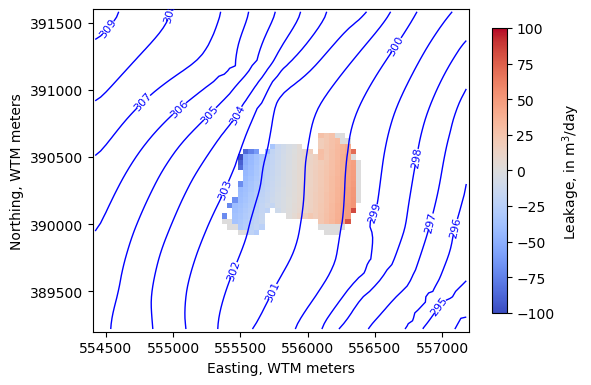

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
ctr = pmv.contour_array(
    wt, levels=np.arange(290, 315, 1), 
    linewidths=1, colors='b')
labels = pmv.ax.clabel(
    ctr, inline=True, 
    fontsize=8, inline_spacing=1)
vmin, vmax = -100, 100
im = pmv.plot_array(
    lak[0], cmap='coolwarm', 
    vmin=vmin, vmax=vmax)
# im = pmv.plot_array(
#     sfr.sum(axis=0), cmap='coolwarm', 
#     vmin=vmin, vmax=vmax)
cb = fig.colorbar(
    im, shrink=0.5, label='Leakage, in m$^3$/day')
ax.set_ylabel("Northing, WTM meters")
ax.set_xlabel("Easting, WTM meters")
ax.set_aspect(1)
plt.tight_layout()
plt.savefig('results.pdf')

### References

Fienen, M.N., Haserodt, M.J., Leaf, A.T., Westenbroek, S.M., 2022, Simulation of Regional Groundwater Flow and Groundwater/Lake Interactions in the Central Sands, Wisconsin: U.S. Geological Survey Scientific Investigations Report 2022-5046, http://doi.org/10.3133/sir20225046

Fienen, M.N., Haserodt, M.J., and Leaf, A.T, 2021, MODFLOW models used to simulate groundwater flow in the Wisconsin Central Sands Study Area, 2012-2018, U.S. Geological Survey Data Release, https://doi.org/10.5066/P9BVFSGJ

Leaf, A.T., Fienen, M.N. and Reeves, H.W. (2021), SFRmaker and Linesink-Maker: Rapid Construction of Streamflow Routing Networks from Hydrography Data. Groundwater, 59: 761-771. https://doi.org/10.1111/gwat.13095